In [20]:
import tensorflow as tf
from tensorflow import keras
from skimage import io
from skimage.io import imread_collection
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil

## Fetch Data (Images)
We begin by fetching a dataset of 10,000 images from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com). We do so by requesting from the endpoint `thispersondoesnotexist.com/images` 10,000 (k) times.

In [21]:
def fetch_images(k: int, folder_name: str):
    """ 
    Fetch images from thispersondoesnotexist.com
    
    :param k: number of images to fetch
    :param folder_name: name of folder to save images to
    """
    if k < 1:
        return 0
    
    # Locals
    count = 0
    endpoint = 'image'
    url = f'https://thispersondoesnotexist.com/{endpoint}'
    while count < k:
        image = requests.get(url).content
        with open(f'{folder_name}/img_{count}.png', 'wb') as f:
            f.write(image)
        count += 1
        
        # A times.sleep(x) is recommended to avoid latency errors

We can now call this function and store the images locally

```python
fetch_images(k=10_000, folder_name='images')
```

## Validating image
We should validate wether the image exists

In [22]:
def image_exists(folder_name:str) -> bool:
    """ 
    Check whether an image exists in folder_name
    
    :param folder_name: folder in which dataset images are located
    """
    try:
        # Default image 0
        image = io.imread(f'{folder_name}/img_0.png')
        return (True, image)
    except:
        print(f'Image "img_0.png" in {folder_name} not found')
        return False

## Showing a batch
We can see a random batch of images from the dataset

In [23]:
def show_batch(batch):
    images = np.random.randint(low=0, high=len(batch), size=16) # get random indices
    fig = plt.figure(figsize= (4, 4)) 
    fig, axs = plt.subplots(4,4, sharex=True, sharey=True)
    cnt = 0 
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(batch[images[cnt]]) # get image from batch at index 'i'
            cnt += 1
    plt.show()

### Image Attributes

In [24]:
def img_attr(batch):
    print(f'Images are {batch[0].shape[0]} by {batch[0].shape[1]} with {batch[0].shape[2]} channels')

---

Retreive all images from dataset

In [25]:
collection = imread_collection("./images/*.png")

In [26]:
len(collection)

10000

<Figure size 288x288 with 0 Axes>

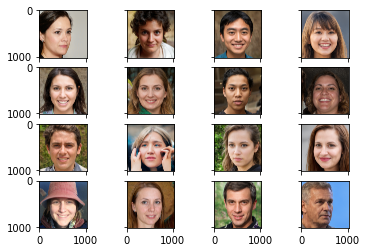

In [27]:
show_batch(collection)

In [28]:
collection[0].shape

(1024, 1024, 3)

In [29]:
img_attr(collection)

Images are 1024 by 1024 with 3 channels


### Neural Network - 1.0
We begin by definning attributes. All images in the dataset are from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com), therefore all images are $1024 \times 1024$ with $3$ channels

In [30]:
rows = collection[0].shape[0]
cols = collection[0].shape[1]
channels = collection[0].shape[2]

In [31]:
image_shape = (rows, cols, channels)

`z_dim` represents the dimenions of the noise vector to be inputed into the generator

We first import libraries to be used

In [98]:
from keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, UpSampling2D, Activation, Conv2D, BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [99]:
z_dim = 512 # 512 is a good default

We implement the schematics for $G(z)$ to generate $1024 \times 1024$ images from [Marchesi, Marco. (2017). Megapixel Size Image Creation using Generative Adversarial Networks.](https://www.researchgate.net/publication/317300265_Megapixel_Size_Image_Creation_using_Generative_Adversarial_Networks), [Karras, Aila. (2018). Progressive Growing of GANs for Improved Quality Stability, and Variation.](https://arxiv.org/pdf/1710.10196.pdf)

#### Generator 

In [154]:
def create_generator(z):
    model = Sequential()
    
    # Input Latent vector
    model.add(Dense(512, input_dim=z))
    model.add(Reshape((1, 1, 512)))
    
    # Conv 1.0 (4x4) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=4, padding='valid'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 2.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 3.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 4.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 5.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(512, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 6.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(256, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(256, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 7.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(128, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 8.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(64, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 9.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(32, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    
    # Conv 10.0 (3x3) -> LeakyReLU -> (3x3) -> LeakyReLU
    model.add(Conv2DTranspose(16, kernel_size=3, strides=2, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(16, kernel_size=3, padding='same')) 
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(3, kernel_size=1, padding='valid')) 
    model.add(LeakyReLU(alpha=0.1))

    model.add(Activation('tanh'))
    return model

In [155]:
def test_gen(z):
    gen = create_generator(z)
    noise = tf.random.normal([1, 512],)
    fake_image = gen(noise, training=False)
    plt.imshow(fake_image[0, :, :, :])
    print(fake_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[[ 4.19559276e-09 -4.06165296e-10  3.54421270e-09]
   [ 8.50698678e-11  3.82876797e-09  2.47355936e-09]
   [-8.18951504e-11  5.46368151e-09  2.49977239e-09]
   ...
   [-6.66718547e-09  7.20705984e-08  8.04682330e-08]
   [-2.33417641e-09  1.10394192e-08  1.66352843e-09]
   [ 3.82157372e-09  4.99764674e-08  8.54389981e-09]]

  [[-1.12413878e-09 -8.55447824e-10  1.58844902e-08]
   [ 1.74402661e-08 -1.35495115e-09  1.18929799e-08]
   [-1.42860335e-09 -4.14472817e-10  1.86653857e-08]
   ...
   [ 7.38507300e-09 -8.48689208e-09  2.10648196e-07]
   [-1.89655225e-09 -6.62715394e-09  9.04313353e-08]
   [ 1.72934289e-08 -8.91990304e-09  1.06181162e-07]]

  [[ 2.62636646e-09 -2.13070964e-10 -3.55685863e-11]
   [-1.05779863e-09 -1.35490641e-09  2.18540048e-08]
   [-1.56534607e-09 -2.91452723e-10  1.11121805e-08]
   ...
   [-1.48882850e-09  4.49803039e-08  8.33986888e-08]
   [-1.70781722e-11 -9.85763249e-10  3.38774768e-08]
   [-6.58205890e-09  3.49241667e-08  5.40755423e-08]]

  ...

 

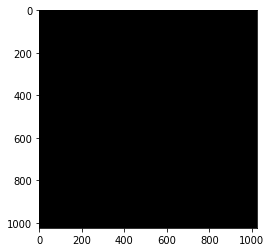

In [156]:
test_gen(z_dim)

#### Discriminator

In [64]:
def create_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=1, padding='same', input_shape=img_shape))
    model.add(Conv2D(16, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
    
    # Conv 2.0
    model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(64, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 3.0
    model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 4.0
    model.add(Conv2D(256, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(256, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 5.0
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 6.0
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 7.0
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 8.0
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Final 
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(512, kernel_size=3, strides=2, padding='valid', input_shape=img_shape))
    
    # Finalized
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

#### Set up (S) - 1.1 Create
We begin by initializing the discriminator and generator

In [65]:
generator = create_generator(output_shape=image_shape, z=z_dim)
discriminator = create_discriminator(img_shape=image_shape)

#### S - 1.2 Compile 
We know compile both models. <br>
NOTE: _Implement OS exisitng model loading_

##### Generator Compile

In [70]:
generator.compile(loss='binary_crossentropy', 
                  optimizer=Adam())

##### Discriminator Compile

In [71]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

#### S - 1.3 Disable Discriminator Training

In [72]:
discriminator.trainable = False